# Config

In [1]:
import os
import json
import time
import torch
import pprint
import random
import pandas
import argparse
import lightning


import numpy as np
import mdtraj as md
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset

In [2]:
def compute_dihedral(positions):
	"""http://stackoverflow.com/q/20305272/1128289"""
	def dihedral(p):
		if not isinstance(p, np.ndarray):
			p = p.numpy()
		b = p[:-1] - p[1:]
		b[0] *= -1
		v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
		
		# Normalize vectors
		v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
		b1 = b[1] / np.linalg.norm(b[1])
		x = np.dot(v[0], v[1])
		m = np.cross(v[0], b1)
		y = np.dot(m, v[1])
		
		return np.arctan2(y, x)

	angles = np.array(list(map(dihedral, positions)))
	return angles

In [7]:
molecule = "alanine"
temperature = "300.0"
version = "250n-v1"

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]

# XYZ Dataset

In [14]:
dataset = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned.pt")
dataset.shape

torch.Size([10000, 22, 3])

In [15]:
label = torch.load(f"../dataset/{molecule}/{temperature}/{version}/label.pt")
label.shape

torch.Size([10000])

In [12]:
phi = compute_dihedral(dataset[:, PHI_ANGLE])
psi = compute_dihedral(dataset[:, PSI_ANGLE])

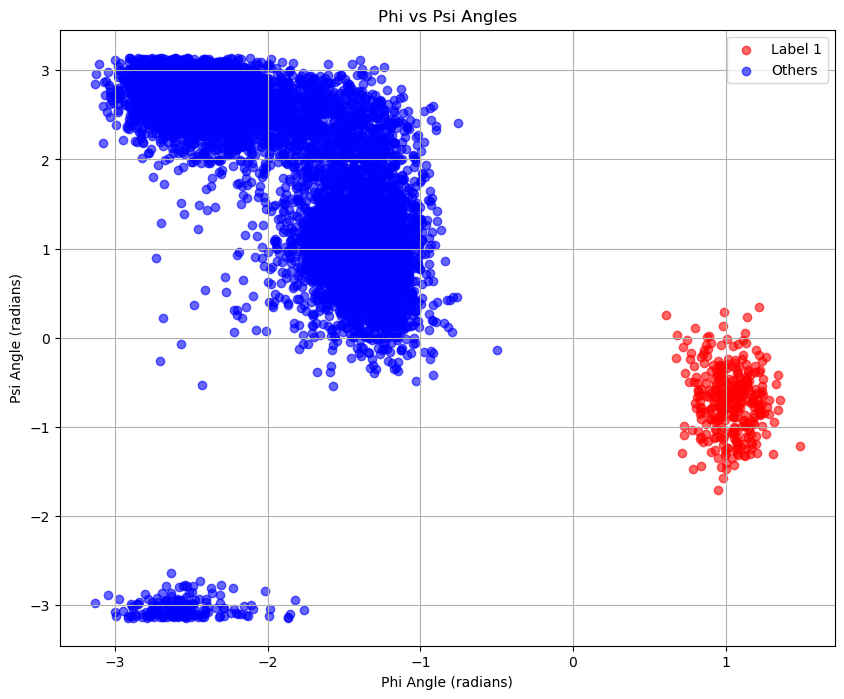

In [16]:


# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(phi[label == 1], psi[label == 1], c='red', label='Label 1', alpha=0.6)
plt.scatter(phi[label != 1], psi[label != 1], c='blue', label='Label 0', alpha=0.6)
plt.xlabel('Phi Angle (radians)')
plt.ylabel('Psi Angle (radians)')
plt.title('Phi vs Psi Angles')
plt.legend()
plt.grid(True)
plt.show()

# Convert

In [13]:
current = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned.pt")
timelag = torch.load(f"../dataset/{molecule}/{temperature}/{version}/xyz-aligned-timelag.pt")
xyz_timelag = torch.stack([current, timelag], dim=1).reshape(current.shape[0], 2, -1)
print(xyz_timelag.shape)
torch.save(xyz_timelag, f"../dataset/{molecule}/{temperature}/{version}/xyz-tbg.pt")

torch.Size([10000, 2, 66])


In [14]:
current_distance = torch.load(f"../dataset/{molecule}/{temperature}/{version}/distance.pt")
timelag_distance = torch.load(f"../dataset/{molecule}/{temperature}/{version}/distance-timelag.pt")
tbg_timelag = torch.stack([current_distance, timelag_distance], dim=1).reshape(current_distance.shape[0], 2, -1)
print(tbg_timelag.shape)
torch.save(tbg_timelag, f"../dataset/{molecule}/{temperature}/{version}/distance-tbg.pt")

torch.Size([10000, 2, 45])


## Load and preprocess

In [21]:
state_list = []
positive_list = []
negative_list = []

for data in tqdm(dataset):
	current_state, positive, negative, _, _ = data
	state_list.append(current_state)
	positive_list.append(positive)
	negative_list.append(negative)

  0%|          | 0/40000 [00:00<?, ?it/s]

In [22]:
state_list = np.stack(state_list)
positive_list = np.stack(positive_list)
negative_list = np.stack(negative_list)

## Visualization

NameError: name 'state_psi_list' is not defined

<Figure size 640x480 with 0 Axes>

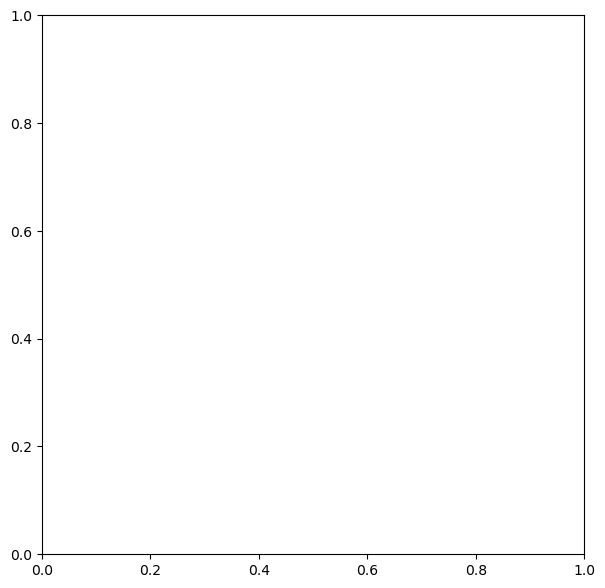

In [25]:
plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.plot(
	state_phi_list,
	state_psi_list,
	marker="o",
	linestyle="None",
	markersize=1,
	alpha=1.0,
	zorder=100,
 	color="green",
)
ax.plot(
	positive_phi_list,
	positive_psi_list,
	marker="o",
	linestyle="None",
	markersize=1,
	alpha=1.0,
	zorder=100,
 	color="blue",
)
ax.plot(
	negative_phi_list,
	negative_psi_list,
	marker="o",
	linestyle="None",
	markersize=1,
	alpha=1.0,
	zorder=100,
 	color="red",
)

# Plot the Ramachandran plot
plt.xlim([-np.pi - 0.1, np.pi + 0.1])
plt.ylim([-np.pi - 0.1, np.pi + 0.1])
plt.xlabel("phi")
plt.ylabel("psi")
plt.show()

# Distance dataset

In [51]:
dataset = torch.load(f"../dataset/{molecule}/{temperature}/{version}/cl-distance.pt")

### Load dataset

In [52]:
state_list = []
positive_list = []
negative_list = []

for data in tqdm(dataset):
	current_state, positive, negative, _, _ = data
	state_list.append(current_state)
	positive_list.append(positive)
	negative_list.append(negative)

  0%|          | 0/4000000 [00:00<?, ?it/s]

In [53]:
state_list = np.stack(state_list)
positive_list = np.stack(positive_list)
negative_list = np.stack(negative_list)

print(state_list.shape, positive_list.shape, negative_list.shape)

(4000000, 45) (4000000, 45) (4000000, 45)


### Visualization

<Figure size 640x480 with 0 Axes>

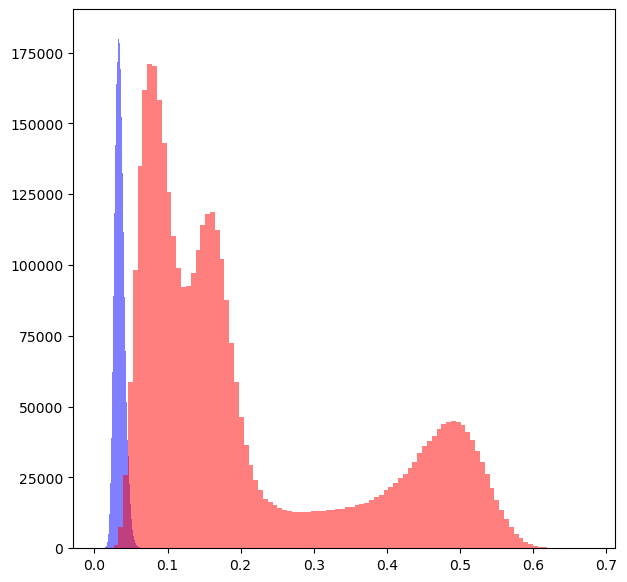

In [54]:
positive_distance_list = np.linalg.norm(positive_list - state_list, axis=1)
negative_distance_list = np.linalg.norm(negative_list - state_list, axis=1)

plt.clf()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.hist(positive_distance_list, bins=100, alpha=0.5, color="blue", label="Positive")
ax.hist(negative_distance_list, bins=100, alpha=0.5, color="red", label="Negative")
plt.show()